# Importing dependencies

In [1]:
# import dependencies
import os
import numpy as np
import  pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dropout, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import pathlib
import random
import warnings
import cv2
from tensorflow.keras import backend as K
import tensorflow_hub as hub
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
warnings.filterwarnings("ignore")
sns.set()

# Handling data preprocessing

In [2]:
# data directories
datadir = "../input/maizedisease/data/"

In [3]:
# process the data paths
dataroot = pathlib.Path(datadir)
all_images = dataroot.glob("*/*")
all_images = [str(path) for path in all_images]

In [4]:
# process the paths to a correct format
all_image_paths = []
for i in all_images:
    if i == '../input/maizedisease/data/fall army worm/.ipynb_checkpoints':
        del i
    else:
        all_image_paths.append(i)

In [5]:
# getting the label names
label_names = sorted(item.name for item in dataroot.glob('*/') if item.is_dir())
label_names

['fall army worm',
 'healthy',
 'herbicide burn',
 'magnesium deficiency',
 'maize streak',
 'multiple',
 'nitrogen deficiency',
 'potassium deficiency',
 'stalk borer',
 'sulphur deficiency',
 'zinc deficiency']

In [6]:
# convert label names to index
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'fall army worm': 0,
 'healthy': 1,
 'herbicide burn': 2,
 'magnesium deficiency': 3,
 'maize streak': 4,
 'multiple': 5,
 'nitrogen deficiency': 6,
 'potassium deficiency': 7,
 'stalk borer': 8,
 'sulphur deficiency': 9,
 'zinc deficiency': 10}

In [7]:
# get the all image labels
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [8]:
# load images to arrays
image_array = []
for i in all_image_paths:
    img = cv2.imread(i)
    img_array = cv2.resize(img,(224,224),3)
    image_array.append(img_array)

In [9]:
# Convert the data to array
train_x=np.array(image_array)
train_y=np.array(all_image_labels)

# Modelling

In [10]:
# url for the pretrained model
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/3" #@param {type:"string"}

In [11]:
# defining a feature extractor function
def feature_extractor(x):
    feature_extractor_module = hub.Module(feature_extractor_url)
    return feature_extractor_module(x)

# get required image size
IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))
IMAGE_SIZE

[224, 224]

In [12]:
# Wraping the module in a keras layer
features_extractor_layer = tf.keras.layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])

In [13]:
# set the layers to be non trainable
features_extractor_layer.trainable = False

In [14]:
# Attaching a classification head
model = tf.keras.Sequential([
  features_extractor_layer,
  tf.keras.layers.Dense(11, activation='softmax')
])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1001)              0         
_________________________________________________________________
dense (Dense)                (None, 11)                11022     
Total params: 11,022
Trainable params: 11,022
Non-trainable params: 0
_________________________________________________________________


In [15]:
# define sessions
sess = K.get_session()
init = tf.global_variables_initializer()

In [16]:
# Initialize the TFHub module.
init = tf.global_variables_initializer()
sess.run(init)

In [17]:
# compiling the model
model.compile(
  optimizer=tf.keras.optimizers.Adam(), 
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

In [18]:
# class to collect the training logs
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])

In [19]:
# compute the class weight to handle imbalanced class
class_weight = compute_class_weight('balanced', np.unique(train_y),
                                train_y)
class_weight

array([ 0.13156693,  2.06698565,  2.70846395, 11.22077922,  5.23636364,
        2.31016043, 19.63636364, 39.27272727, 11.22077922, 26.18181818,
        0.61363636])

In [20]:
# compute steps per epoch and define the batches
steps_per_epoch = len(image_array)//32
batch_stats = CollectBatchStats()

In [21]:
# Train the model
model.fit(train_x,y = train_y,epochs=100, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats],batch_size=32, class_weight=class_weight)

Epoch 1/100
27/27 [==============================] - 38s 1s/step - loss: 1.5752 - acc: 0.5940
Epoch 2/100
27/27 [==============================] - 33s 1s/step - loss: 0.9333 - acc: 0.7032
Epoch 3/100
27/27 [==============================] - 33s 1s/step - loss: 0.7623 - acc: 0.7224
Epoch 4/100
27/27 [==============================] - 33s 1s/step - loss: 0.6770 - acc: 0.7497
Epoch 5/100
27/27 [==============================] - 33s 1s/step - loss: 0.6160 - acc: 0.7725
Epoch 6/100
27/27 [==============================] - 33s 1s/step - loss: 0.5677 - acc: 0.7956
Epoch 7/100
27/27 [==============================] - 33s 1s/step - loss: 0.5273 - acc: 0.8116
Epoch 8/100
27/27 [==============================] - 33s 1s/step - loss: 0.4928 - acc: 0.8267
Epoch 9/100
27/27 [==============================] - 33s 1s/step - loss: 0.4630 - acc: 0.8396
Epoch 10/100
27/27 [==============================] - 33s 1s/step - loss: 0.4368 - acc: 0.8472
Epoch 11/100
27/27 [==============================] - 33s 1

In [22]:
model.save("model.h5")

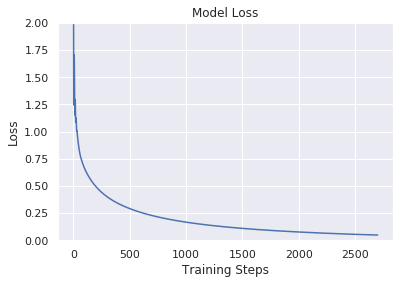

In [23]:
# visualize the training results (loss)
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats.batch_losses)
plt.title("Model Loss")
plt.show()

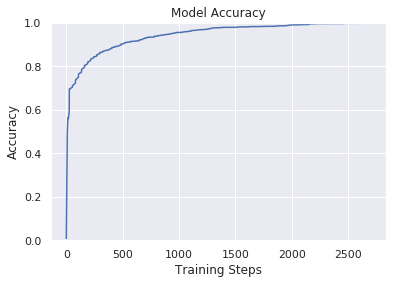

In [24]:
# visualize the training results (accuracy)
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)
plt.title("Model Accuracy")
plt.show()

# Predict for new image

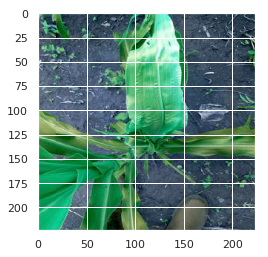

In [25]:
test = cv2.imread(all_image_paths[520])
test = cv2.resize(test,(224,224),3)
plt.imshow(test)

In [26]:
all_image_paths[520]

'../input/maizedisease/data/fall army worm/IMG_20190523_124547_6.jpg'

In [27]:
test = test.reshape(1,224,224,3)

In [28]:
pred = model.predict(test)
pred

array([[9.84424710e-01, 4.71718097e-03, 1.15480652e-04, 7.27210954e-06,
        7.32975650e-07, 1.21021185e-04, 4.11920109e-10, 8.12007784e-06,
        9.10798190e-05, 2.10534637e-07, 1.05140619e-02]], dtype=float32)

In [29]:
predicted_label = label_names[np.argmax(pred)]
predicted_label

'fall army worm'